# 1-1 사진 준비

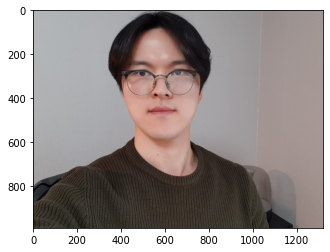

In [6]:
# 모듈 임포트

    # 웹에서 데이터 다운로드시 사용함
import urllib       

    # 시멘틱 세그멘테이션 라이브러리
from pixellib.semantic import semantic_segmentation

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt 

# 데이터 로드
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.jpg'  
img_orig = cv2.imread(img_path) 

# 데이터 확인
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 1-2 시멘틱 세그멘테이션 다루기

In [8]:
# 1. 모델 다운로드

    # 저장 파일 폴더 및 이름 만들기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

    # 다운로드 url 지정
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

    # 다운로드 시작
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f1291851d60>)

In [11]:
# 2. 세그먼테이션 모델 생성: pixellib

    # 모델 생성
model = semantic_segmentation()

    # pascal voc 데이터로 학습된 모델 이용
model.load_pascalvoc_model(model_file)



                                             
                                             

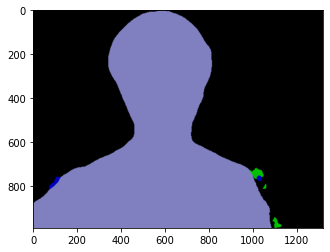

{'class_ids': array([ 0,  9, 15, 18]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])}
background
chair
person
sofa


In [22]:
# 3. 모델 적용 및 확인

    # 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

    # PASCAL VOC 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

    # 모델 segvalues 및 output 학인
plt.imshow(output)
plt.show()

print(segvalues)

    # segmentation 대상 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])



[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]
[192 128 128]


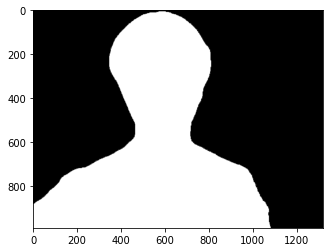

(990, 1320)


In [35]:
# 4. 세그멘테이션 실행 : 사람 이미지 마스크 생성

    # 분류된 물체의 색상 알아내기 : calss_ids=[0, 9, 15, 18]
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20])


    # 물체(사람) 색상 알아내기 (출력값은 BGR순서로 채널 배치)
print(colormap[15])

    # RGB 순서로 색상 객체 정의
seg_color = (128,128,192)

    # 사람(seg_color)으로 이뤄진 영약 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1)   #output 픽셀별로 색상이 seg_color와 같다면 True, 아니면 False
plt.imshow(seg_map, cmap='gray')
plt.show()
print(seg_map.shape)   # 출력값에 3채널 정보가 사라짐

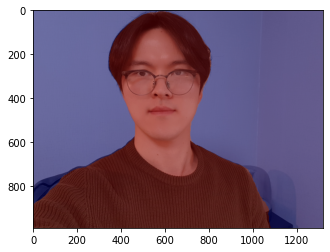

In [47]:
# 5. 세그멘테이션 실행 : 원본 이미지에 마스크 적용하기

    # 원본 이미지 카피하기
img_show = img_orig.copy()

    # (Treu,False) 값을 각각 (255,0) 으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255   # astype(np.unit8) 은 정수 변환을 의미

    # 255와 0을 다른 색상으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스크 합치기 : 이미지 비율(0.6:0.4)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

plt.show()

# 1-3 배경 흐리게 하기

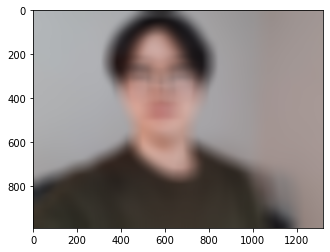

In [75]:
# 1. 사진 전체 흐리게 만들기 : cv.blur()

img_orig_blur = cv2.blur(img_orig, (75,75))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

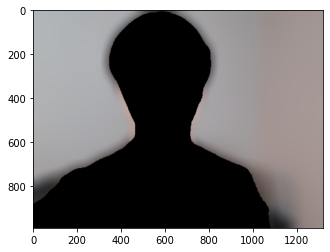

In [76]:
# 2. 배경만 흐리게 만들기 : cv2.bitwise

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # bitswise_not 함수 : 이미지 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)

    # bitwise_and 함수 : 이미지 곱하기(전체 블러 x 마스크(배경:1, 사람:0)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 1-4 원본 이미지와 흐린 배경 합치기

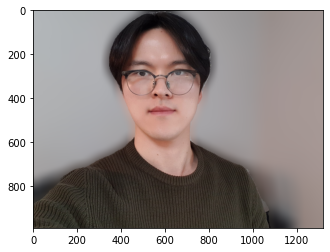

In [78]:
# 흐린 배경 + 원본 사람 : np.where()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 2-1 사진 준비

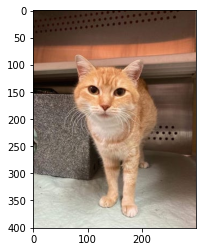

In [84]:
# 모듈 임포트

import urllib
from pixellib.semantic import semantic_segmentation
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 데이터 로드
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'
img_orig = cv2.imread(img_path)

# 데이터 확인
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


# 2-2 시멘틱 세그멘테이션 나누기

In [93]:
# 2. 세그멘테이션 모델 생성 : pixellib

    # 모델 생성
model = semantic_segmentation()

    # 모델에 pascal voc 데이터로 학습된 모형 적용
model.load_pascalvoc_model(model_file)

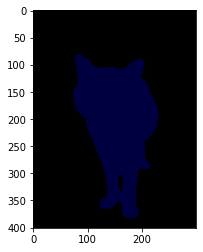

{'class_ids': array([0, 8]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
background
cat


In [101]:
# 3. 모델 적용 및 확인

    # 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)
    
    # PASCAL VOC 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]    
    
    # 모델 segvalues 및 output 확인
plt.imshow(output)
plt.show()

print(segvalues)

    # segmentation 대상 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
    
    

[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]
---------------------------
[64  0  0]


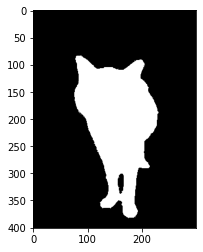

In [116]:
# 4. 세그멘테이션 실행 - 사람 이미지 마스크 생성 : np.all()

    # 분류된 물체의 색상 알아내기
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20])

    # 물체(고양이) 색상 알아내기
print("---------------------------")
print(colormap[8])

    # RBG 순서로 색상 객체 정의
seg_color = (0, 0, 64)

    # 사람(seg_color)로 이뤄진 영역 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1)
plt.imshow(seg_map, cmap='gray')
plt.show()


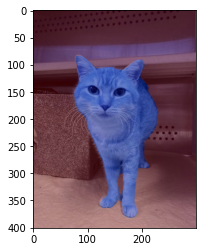

In [136]:
# 5. 세그멘테이션 실행 - 원본 이미지에 마스크 적용 후 이미지 합치기 : cv2.addWeighted()

    # 원본 이미지 카피하기
img_show = img_orig.copy()

    # (True, False) 값을 각각 (255,0)으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

    # 255와 0을 다른 색상으로 변경 
        #cv2.applyColorMap(inputArray scr, outputArray dst, InputArray userColor)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스크 합치기 : 이미지 비율(0.6:0.4)
        # cv.addWeighted( src1, alpha, src2, beta, gamma[, dst[, dtype]] )
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) 

plt.imshow(img_show)
plt.show()




# 2-3 배경 흐리게 하기 

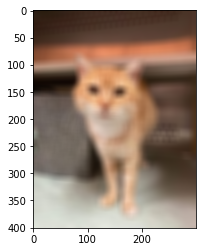

In [144]:
# 1. 배경 흐리게 하기 cv2.blur()

img_orig_blur = cv2.blur(img_orig, (15,15))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

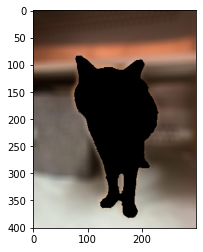

In [156]:
# 2. 배경만 흐리게 만들기 : cv2.bitwise

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # bitwise_not 함수 : 이미지 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.imshow(img_bg_mask)

    # bitwise_and 함수 : 이미지 곱하기(전체 블러 x 배경 마스크)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

# 2-4 원본 이미지와 흐린 배경 합치기

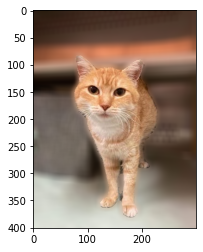

In [159]:
# 원본이미지와 흐린배경 합치기 : np.where()
    # np.where(조건, 참일 때, 거짓일 때)
    
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


# 3-1 크로마키 만들기 : 데이터 준비

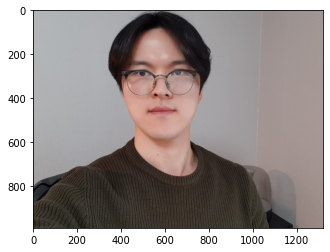

In [205]:
# 모둘 임포트
import urllib
from pixellib.semantic import semantic_segmentation
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# 데이터 로드
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.jpg'  
img_orig = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

# 3-2 크로마키 만들기 : 마스크 만들기

In [173]:
# 2. 세그먼테이션 모델 생성 : pixellib

    # 모델 생성
model = semantic_segmentation()

    # paxcal voc 데이터로 적용
model.load_pascalvoc_model(model_file)

{'class_ids': array([ 0,  9, 15, 18]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])}
background
chair
person
sofa


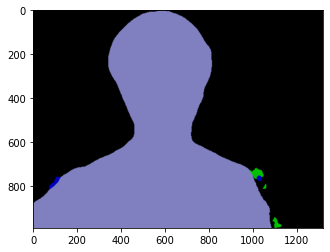

In [193]:
# 3. 모델 적용 및 확인

    # 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

    # PASCAL VOC 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

    # 모델 segvalus 및 output 확인
plt.imshow(output)
print(segvalues)

    # segmentation 대상 확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]
---------------------
[192 128 128]


<function matplotlib.pyplot.show(close=None, block=None)>

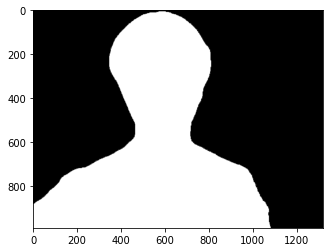

In [194]:
# 4. 세그멘테이션 실행 : 사람 이미지 마스크  생성

    # 분류된 물체의 색상 알아내기 : 코드 제시
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20])


    # 물체(사람) 색상 알아내기
print("---------------------")
print(colormap[15])

    # RGB 순서로 색상 객체 정의
seg_color = (128, 128, 192)

    # 사람 형상 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1)
plt.imshow(seg_map, cmap='gray')
plt.show

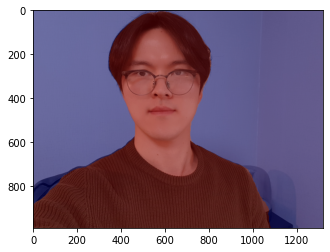

In [201]:
# 5. 세그멘테이션 실행 : 원본 이미지 마스크 적용하기

    # 원본 이미지 카피
img_show = img_orig.copy()

    # (TRUE, False) 값을 (255,0)으로 만들기
img_mask = seg_map.astype(np.uint8) * 255

    # img 마스크에 색상입히기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스크 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

# 3-3 크로마키 만들기 : 배경 만들기

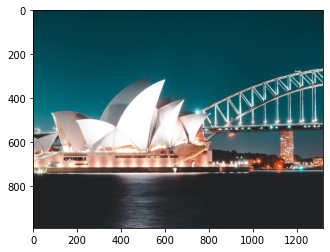

In [226]:
# 1. 배경이미지 로드

img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/operahouse2.jpg'  
img_orig2 = cv2.imread(img_path2)

plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [207]:
# 2. 배경 마스크 만들기

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
img_bg_mask = cv2.bitwise_not(img_mask_color)

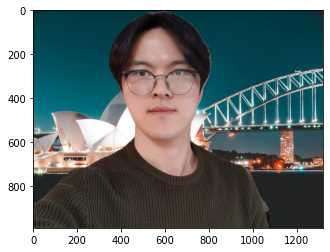

In [228]:
# 3. 배경 마스크와 배경 이미지 합치기

img_concat = np.where(img_mask_color==255, img_orig, img_orig2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 세그멘테이션 상 문제점 및 해결

- (문제) 사람 이미지와 연결되는 부위(의자 등판, 배경에 사물)등이 세그멘테이션시 사람 이미지와 구별되지 못하는 문제점 발생
- (원인) sementic segmentation의 성능이 카메라로 파사계심도를 직접 조절하여 촬영한 이미지 만큼 정밀하지 못함

- (해결방안) Decoder를 개선한 모델 활용
    - DeConNet과 같이 인코더와 디코더를 대칭으로 만든 딥러닝 모델 활용 가능
        - Convolution Network는 VGG 16을 사용하며 13개의 층으로 구성됨
        - Deconvolution Network는 Unpooling, Deconvolution, RelU로 이뤄짐
    - Unpooling과 Transposed convolution이 반복적으로 이루어짐
        - Transposed convolution은 전반적인 경계 포착
        - Unpooling은 디테일한 경계를 포착
    
    - Decoder 성능이 뛰어난 DeConNet 적용 
        - pixellib 모델은 이용 상 편의가 있지만 semantic segmentation의 정밀도가 부족함
        - 따라서 DeConNet을 이용하여 마스크를 구분할 경우, 사람 이미지와 배경의 경계선이 명확하게 구분되어 배경에 대한 blur처리가 보다 명확하게 적용될 것으로 예상함

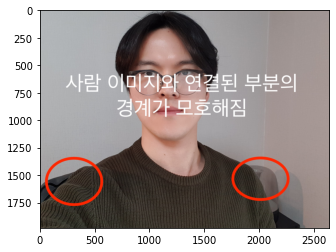

In [230]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image4.jpg'  
img_orig3 = cv2.imread(img_path3)

plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()
